## taxonomy training

In [1]:
# Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool, cv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import collections
import pickle
from sklearn.metrics import classification_report
from catboost.utils import get_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### Load train and test file

In [2]:
%%time
train_pool = Pool("../data/taxonomy_dataset_train_full.tsv", 
               column_description="../data/columns_description.cd")
val_pool = Pool("../data/taxonomy_dataset_validation_removed_low_freq_full.tsv", 
               column_description="../data/columns_description.cd")
test_pool = Pool("../data/taxonomy_dataset_test_removed_low_freq_full.tsv", 
               column_description="../data/columns_description.cd")

CPU times: user 4min 11s, sys: 29.1 s, total: 4min 40s
Wall time: 2min 35s


### Data shape

In [3]:
train_pool.shape

(35133, 68509)

In [4]:
val_pool.shape

(9900, 68509)

In [5]:
test_pool.shape

(4960, 68509)

In [6]:
train_labels = train_pool.get_label()
label_count = collections.Counter(train_labels).most_common()
print("Number of classes:", len(label_count))
for label, count in label_count:
    print(count, '\t', label)

Number of classes: 117
7383 	 root:Mixed
6120 	 root:Host-associated:Human:Digestive system:Large intestine:Fecal
1567 	 root:Environmental:Aquatic:Freshwater:Lake
1519 	 root:Host-associated:Human:Reproductive system:Vagina
1474 	 root:Host-associated:Human:Skin
1136 	 root:Host-associated:Mammals:Digestive system
978 	 root:Environmental:Aquatic:Marine
977 	 root:Host-associated:Human:Respiratory system:Nasopharyngeal
823 	 root:Environmental:Aquatic
805 	 root:Host-associated:Human:Digestive system:Oral
627 	 root:Environmental:Terrestrial:Soil:Agricultural
622 	 root:Environmental:Terrestrial:Soil
598 	 root:Host-associated:Human:Digestive system
574 	 root:Engineered:Food production:Dairy products
552 	 root:Host-associated:Mammals:Gastrointestinal tract
486 	 root:Host-associated:Human:Digestive system:Large intestine:Sigmoid colon
473 	 root:Host-associated:Plants:Rhizosphere
442 	 root:Environmental:Aquatic:Marine:Sediment
440 	 root:Host-associated:Mammals:Digestive system:Lar

### Load trained model 

In [7]:
# Init the model
model = CatBoostClassifier(
            custom_loss=['Accuracy'],# this line needs to be commented out if using pretrained model
            learning_rate=0.015,
            random_seed=42,
            iterations=5000,
            auto_class_weights = 'Balanced',
            task_type="GPU"
            )
trained_model = 'taxonomy_model_full_lr_0.015_itr_5000.json'
# if os.path.exists(trained_model):
#     model.load_model(trained_model, format='json')

### Model training

In [8]:
# Train
model.fit(
    train_pool,
    eval_set=val_pool,
    logging_level='Verbose',
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4.6840733	test: 4.7116941	best: 4.7116941 (0)	total: 202ms	remaining: 16m 48s
1:	learn: 4.5994442	test: 4.5957202	best: 4.5957202 (1)	total: 348ms	remaining: 14m 28s
2:	learn: 4.5260309	test: 4.5191095	best: 4.5191095 (2)	total: 489ms	remaining: 13m 34s
3:	learn: 4.4460626	test: 4.4564897	best: 4.4564897 (3)	total: 636ms	remaining: 13m 13s
4:	learn: 4.3847552	test: 4.3894632	best: 4.3894632 (4)	total: 779ms	remaining: 12m 58s
5:	learn: 4.3339365	test: 4.3260425	best: 4.3260425 (5)	total: 919ms	remaining: 12m 45s
6:	learn: 4.2845492	test: 4.2402856	best: 4.2402856 (6)	total: 1.06s	remaining: 12m 37s
7:	learn: 4.2569480	test: 4.2024075	best: 4.2024075 (7)	total: 1.2s	remaining: 12m 29s
8:	learn: 4.2073017	test: 4.1615423	best: 4.1615423 (8)	total: 1.35s	remaining: 12m 28s
9:	learn: 4.1686075	test: 4.1473697	best: 4.1473697 (9)	total: 1.49s	remaining: 12m 25s
10:	learn: 4.1323854	test: 4.1108727	best: 4.1108727 (10)	total: 1.64s	remaining: 12m 22s
11:	learn: 4.1060666	test: 4.07

### Save model

In [9]:
# save model
model.save_model(trained_model,
           format="json",
           export_parameters=None,
           pool=train_pool)

### Prediction

In [10]:
model.score(test_pool)

0.9973790322580646

In [11]:
model.get_best_score()

{'learn': {'Accuracy:use_weights=true': 0.9988810522030082,
  'Accuracy:use_weights=false': 0.9978367916204138,
  'MultiClass': 0.00577952580917585},
 'validation': {'Accuracy:use_weights=true': 0.9913259022178754,
  'Accuracy:use_weights=false': 0.9970707070707071,
  'MultiClass': 0.03583193813019058}}

### Analysis

In [12]:
X_test = test_pool.get_features()
y_test = test_pool.get_label()
with open('../data/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)
predictions = model.predict(X_test)


### Precision and recall

In [13]:
precision_recall_fscore_support(y_test, predictions, average=None)

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.


(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.98876404, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.98717949, 1.        , 0.99

In [14]:
precision_recall_fscore_support(y_test, predictions, average='micro')

(0.9973790322580646, 0.9973790322580646, 0.9973790322580646, None)

In [15]:
precision_recall_fscore_support(y_test, predictions, average='weighted')

(0.999048044501608, 0.9973790322580646, 0.9981499416318612, None)

In [16]:
precision_recall_fscore_support(y_test, predictions, average=None, labels=model.classes_)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


(array([0.        , 0.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.        ,
        1.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 1.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 1.        , 1.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 0.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.98876404, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.  

### Confusion matrix

In [17]:
confusion_matrix_test = get_confusion_matrix(model, test_pool)
print(confusion_matrix_test.shape)
print(len(model.classes_))
confusion_matrix_test_pd = pd.DataFrame(data=np.log(confusion_matrix_test+0.001), columns=model.classes_, index=model.classes_)

(117, 117)
117


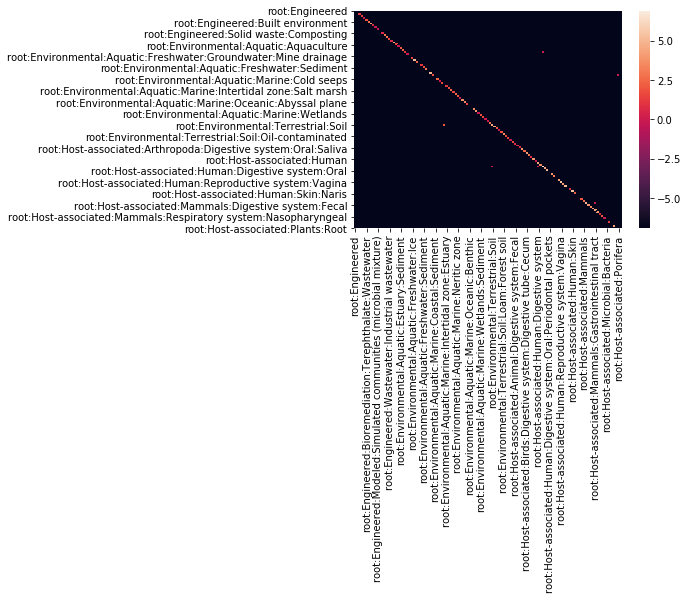

In [18]:
ax = sns.heatmap(confusion_matrix_test_pd)

### Feature importance

In [19]:
model_feature_importance = pd.Series(data=model.feature_importances_, index=model.feature_names_)
model_feature_importance

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
68504    0.0
68505    0.0
68506    0.0
68507    0.0
68508    0.0
Length: 68509, dtype: float64

In [ ]:
sorted_feature_importance = model_feature_importance[model_feature_importance.argsort()]
print(sorted_feature_importance)
plt.figure(figsize=(20,10))
plt.barh(sorted_feature_importance.values,
        sorted_feature_importance.index,
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

0        0.000000
45252    0.000000
45253    0.000000
45254    0.000000
45255    0.000000
           ...   
33655    4.457735
19318    4.689647
51460    6.017504
49565    6.492910
24432    7.134266
Length: 68509, dtype: float64


Text(0.5, 0, 'CatBoost Feature Importance')

### Shap values

In [ ]:
%%time
explainer_model = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer_model.shap_values(X_test)

In [ ]:
%%time
shap.summary_plot(shap_values, X_test, feature_names = feature_names, max_display=50, class_names=model.classes_,show=False)
f = plt.gcf()
plt.savefig('shap_summary_first_50.png',bbox_inches='tight')